### Датасет: 
#### Экземпляры: студенты, их средняя годовая оценка GPA $ \in [0, 100] $, итоговая оценка GradeClass (0, 1, 2, 3, 4) -> (F, D, C, B, A) и различные показатели от которых эти два значения могут зависеть.
#### Размер: 2392 строк, 15 столбцов
#### Целевая функция: GradeClass, задача классификации
#### Очевидно, что GradeClass зависит от GPA (A >= 75, 75 > B > 60 и т.д.), поэтому GPA будет исключено из датасета

In [2705]:
import pandas as pd
import numpy as np

In [2706]:
import torch
from torchsummary import summary

In [2707]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

In [2708]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2709]:
import os
from pathlib import Path

In [2710]:
import kagglehub
rabieelkharoua_students_performance_dataset_path = kagglehub.dataset_download('rabieelkharoua/students-performance-dataset')

print('Data source import complete.')

print(rabieelkharoua_students_performance_dataset_path)

Data source import complete.
/home/michael/.cache/kagglehub/datasets/rabieelkharoua/students-performance-dataset/versions/2


In [2711]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2712]:
df = pd.read_csv(rabieelkharoua_students_performance_dataset_path + '/Student_performance_data _.csv')

In [2713]:
print(df.head())

   StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196         2.0  
1             0  3

### Предобработка данных:

In [2714]:
df = df.drop(columns=['StudentID'])
df = df.drop(columns=['GPA'])
print(df.shape)

(2392, 13)


In [ ]:
# проверка на незаполненность данных

print(df.isna().sum())

Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GradeClass           0
dtype: int64


In [ ]:
# выявление категориальных признаков

for col in df.columns:
    print(col, df[col].unique())

Age [17 18 15 16]
Gender [1 0]
Ethnicity [0 2 1 3]
ParentalEducation [2 1 3 4 0]
StudyTimeWeekly [19.83372281 15.40875606  4.21056977 ...  6.80549964 12.41665266
 17.81990749]
Absences [ 7  0 26 14 17 10 22  1 11 15 21  9 16 29  2 25 20  5  8 12 27 23  3 13
  6 28  4 18 19 24]
Tutoring [1 0]
ParentalSupport [2 1 3 4 0]
Extracurricular [0 1]
Sports [0 1]
Music [1 0]
Volunteering [0 1]
GradeClass [2. 1. 4. 3. 0.]


In [ ]:
# one-hot кодирование признаков, где не прослеживается градация

df['Ethnicity'] = df['Ethnicity'].map({0: 'Caucasian', 1: 'African American', 2: 'Asian', 3: 'Other'})
work_onehot = pd.get_dummies(df['Ethnicity'], prefix='Ethnicity', dtype=float)
df = pd.concat([df.drop('Ethnicity', axis=1), work_onehot], axis=1)

df['ParentalEducation'] = df['ParentalEducation'].map({0: 'None', 1: 'High School', 2: 'Some College', 3: "Bachelor's", 4: 'Higher'})
work_onehot = pd.get_dummies(df['ParentalEducation'], prefix='ParentalEducation', dtype=float)
df = pd.concat([df.drop('ParentalEducation', axis=1), work_onehot], axis=1)

In [2718]:
for col in df.columns:
    print(col, df[col].unique())

Age [17 18 15 16]
Gender [1 0]
StudyTimeWeekly [19.83372281 15.40875606  4.21056977 ...  6.80549964 12.41665266
 17.81990749]
Absences [ 7  0 26 14 17 10 22  1 11 15 21  9 16 29  2 25 20  5  8 12 27 23  3 13
  6 28  4 18 19 24]
Tutoring [1 0]
ParentalSupport [2 1 3 4 0]
Extracurricular [0 1]
Sports [0 1]
Music [1 0]
Volunteering [0 1]
GradeClass [2. 1. 4. 3. 0.]
Ethnicity_African American [0. 1.]
Ethnicity_Asian [0. 1.]
Ethnicity_Caucasian [1. 0.]
Ethnicity_Other [0. 1.]
ParentalEducation_Bachelor's [0. 1.]
ParentalEducation_High School [0. 1.]
ParentalEducation_Higher [0. 1.]
ParentalEducation_None [0. 1.]
ParentalEducation_Some College [1. 0.]


In [2719]:
print(df.shape)

(2392, 20)


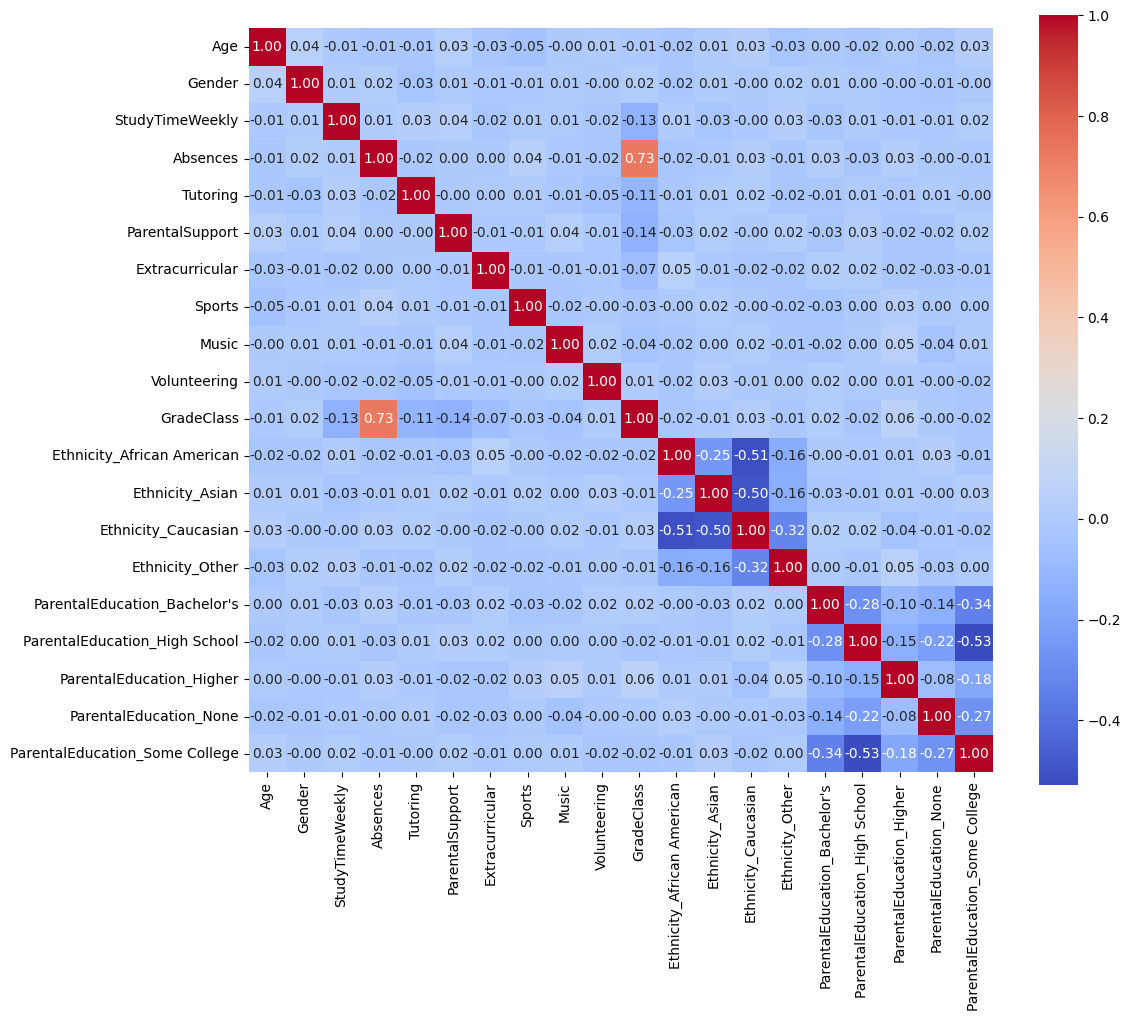

In [ ]:
# построение матрицы корреляций признаков

correlation_matrix = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.show()

In [ ]:
# Отсечение признаков с маленькой корреляцией

target = df['GradeClass'].values
df = df[['GradeClass', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport']]
features = df.drop(columns=['GradeClass']).values
print(features.shape)

# Стандартизация
scaler = StandardScaler()
features = scaler.fit_transform(features)

(2392, 4)


### SMOTE, балансировка классов и создание загрузчиков пакетов для нейронной сети

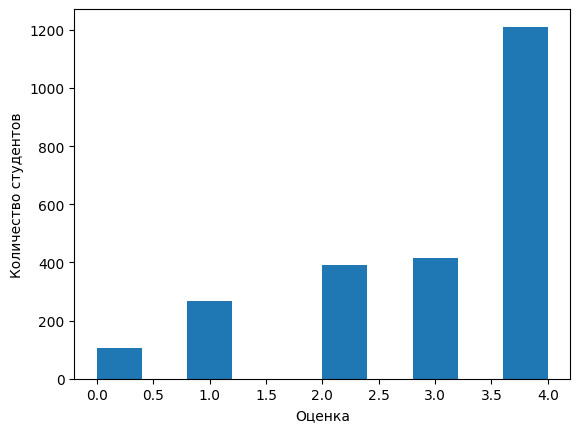

In [ ]:
# Диаграмма для анализа распределения оценок

plt.hist(target)
plt.xlabel("Оценка")
plt.ylabel("Количество студентов")
plt.show()

In [2723]:
print(df['GradeClass'].value_counts())

GradeClass
4.0    1211
3.0     414
2.0     391
1.0     269
0.0     107
Name: count, dtype: int64


In [2724]:
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(target, dtype=torch.long)

In [ ]:
# разбиение выборки на тренировочную и тестовую

train_idx, test_idx = train_test_split(range(len(target)), test_size=0.15, random_state=42)

dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
train_data = torch.utils.data.Subset(dataset, train_idx)
test_data = torch.utils.data.Subset(dataset, test_idx)

batch_size = 64

X_train_subset = X_tensor[train_idx]
y_train_subset = y_tensor[train_idx]

X_train_np = X_train_subset.numpy()
y_train_np = y_train_subset.numpy()

# увеличение числа экземплярова в минорных классах тренировочной выборки при помощи SMOTE

new_counts = {
    0: 107 + 120,
    1: 269 + 50,
    2: 391 + 50,
    3: 414 + 50,
    4: 1211
}

smote = SMOTE(sampling_strategy=new_counts, random_state=42)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train_np, y_train_np)

X_train_smoted_torch = torch.tensor(X_train_smoted, dtype=torch.float32)
y_train_smoted_torch = torch.tensor(y_train_smoted, dtype=torch.long)

smoted_dataset = torch.utils.data.TensorDataset(X_train_smoted_torch, y_train_smoted_torch)

train_loader = torch.utils.data.DataLoader(smoted_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [2726]:
smoted_counts = pd.Series(y_train_smoted).value_counts().sort_index()
print(smoted_counts)

0     227
1     319
2     441
3     464
4    1211
Name: count, dtype: int64


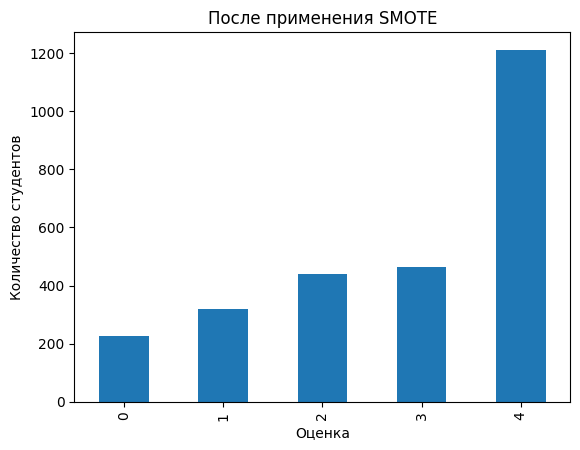

In [2727]:
smoted_counts.plot(kind="bar")
plt.title('После применения SMOTE')
plt.xlabel("Оценка")
plt.ylabel("Количество студентов")

plt.show()

In [2728]:
unique_classes, counts = np.unique(y_train_smoted, return_counts=True)
weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_smoted
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

print(class_weights)

tensor([2.3454, 1.6690, 1.2073, 1.1474, 0.4396], device='cuda:0')


### Нейросеть
#### Ошибка: CrossEntropyLoss
#### Оптимизатор: AdamW
#### Метрики: accuracy и f1_score из (classification_report)
#### Сохранение лучшего по accuracy варианта во время обучения
#### Результаты: прямая визуализация ответа, диаграмма ошибок и правильных ответов, матрица ошибок

In [2729]:
class Net(torch.nn.Module):
    def __init__(self, train_loader, test_loader, device):
        super(Net, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 128),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 64),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, 64),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, 5),
        )

        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

    def forward(self, x):
        return self.layers(x)

    def train_model(self, optimizer, criterion, num_epochs, save_path="best_model.pth"):

        best_acc = 0.0
    
        if not os.path.exists(save_path):
            open(save_path, 'w').close()

        self.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            all_targets = []
            all_predictions = []
            
            for inputs, labels in self.train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                
                all_targets.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            
            epoch_loss = running_loss / len(self.train_loader)
            
            train_report = classification_report(
                all_targets,
                all_predictions,
                target_names=['F', 'D', 'C', 'B', 'A'],
                output_dict=True,
                zero_division=0
            )
            
            train_accuracy = train_report['accuracy']
            train_f1_macro = train_report['macro avg']['f1-score']
            train_f1_weighted = train_report['weighted avg']['f1-score']
            
            test_loss, test_accuracy, test_f1_macro, test_f1_weighted, class_f1 = self.evaluate_model(criterion)
            
            if test_accuracy > best_acc:
                best_acc = test_accuracy
                torch.save({
                    'model_state_dict': self.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': test_loss,
                    'accuracy': test_accuracy,
                    'f1_macro': test_f1_macro,
                    'f1_weighted': test_f1_weighted
                }, save_path)
            print("Best model saved!")

            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {epoch_loss:.4f} | Acc: {train_accuracy:.4f} | F1 (macro): {train_f1_macro:.4f} | F1 (weighted): {train_f1_weighted:.4f}')
            print(f'Test  Loss: {test_loss:.4f} | Acc: {test_accuracy:.4f} | F1 (macro): {test_f1_macro:.4f} | F1 (weighted): {test_f1_weighted:.4f}')
            
            print('\nClass-wise Test F1:')
            for class_name, f1 in class_f1.items():
                print(f'{class_name}: {f1:.4f}', end=' | ')
            print('\n' + '-'*50)


    def evaluate_model(self, criterion):
        self.eval()
        all_targets = []
        all_predictions = []
        running_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                
                all_targets.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
        test_loss = running_loss / len(self.test_loader)
        
        report = classification_report(
            all_targets, 
            all_predictions,
            target_names=['F', 'D', 'C', 'B', 'A'],
            output_dict=True,
            zero_division=0
        )
        
        test_accuracy = report['accuracy']
        test_f1_macro = report['macro avg']['f1-score']
        test_f1_weighted = report['weighted avg']['f1-score']
        
        class_f1 = {f'f1_{k}': v['f1-score'] for k, v in report.items() if k in ['F', 'D', 'C', 'B', 'A']}
        
        return test_loss, test_accuracy, test_f1_macro, test_f1_weighted, class_f1

    def show_results(self):
        self.eval()
        with torch.no_grad():
            outputs = []
            targets = []
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                _, predicted = torch.max(self(inputs).data, 1)
                outputs.append(predicted.squeeze())
                targets.append(labels)

        targets_tensor = torch.cat(targets).cpu().numpy()
        outputs_tensor = torch.cat(outputs).cpu().numpy()

        plt.figure(figsize=(10, 6))
        plt.plot(targets_tensor[:25], alpha=0.3, label='Целевое значение', color='green', linestyle='none', marker='o')
        plt.plot(outputs_tensor[:25], alpha=0.3, label='Предсказания', color='red', linestyle='none', marker='o')
        plt.ylabel("Оценка")
        plt.legend()
        plt.grid()
        plt.ylim(-0.1, 4.1)
        plt.show()

        errors_mask = targets_tensor != outputs_tensor
        correct_mask = targets_tensor == outputs_tensor

        incorrect_targets = targets_tensor[errors_mask]
        correct_targets = targets_tensor[correct_mask]

        error_counts = np.bincount(incorrect_targets.astype(int), minlength=5)
        correct_counts = np.bincount(correct_targets.astype(int), minlength=5)

        plt.figure(figsize=(10, 6))
        plt.bar(range(5), error_counts, color='orange', alpha=0.5, label='Ошибки')
        plt.bar(range(5), correct_counts, color='green', alpha=0.5, bottom=error_counts, label='Верные прогнозы')
        plt.xlabel('Класс')
        plt.ylabel('Количество ошибок')
        plt.title('Распределение правильных и ошибочных прогнозов по классам')
        plt.xticks(range(5), ['F', 'D', 'C', 'B', 'A'])
        plt.legend(loc='upper left')
        plt.grid(axis='y')
        plt.show()

        print(classification_report(targets_tensor, outputs_tensor))
        print("\nConfusion Matrix:")
        print(confusion_matrix(targets_tensor, outputs_tensor))

        sns.heatmap(confusion_matrix(targets_tensor, outputs_tensor), 
                    annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')

In [2730]:
model = Net(train_loader, test_loader, device).to(device)
print(summary(model, (1, 4)))

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

criterion = torch.nn.CrossEntropyLoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             640
           Sigmoid-2               [-1, 1, 128]               0
           Dropout-3               [-1, 1, 128]               0
            Linear-4                [-1, 1, 64]           8,256
           Sigmoid-5                [-1, 1, 64]               0
           Dropout-6                [-1, 1, 64]               0
            Linear-7                [-1, 1, 64]           4,160
           Sigmoid-8                [-1, 1, 64]               0
           Dropout-9                [-1, 1, 64]               0
           Linear-10                 [-1, 1, 5]             325
Total params: 13,381
Trainable params: 13,381
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.05
Estimated Tot

In [2731]:
model.train_model(optimizer, criterion, 50)

Best model saved!

Epoch [1/50]
Train Loss: 1.4579 | Acc: 0.4512 | F1 (macro): 0.1300 | F1 (weighted): 0.2860
Test  Loss: 1.3300 | Acc: 0.5209 | F1 (macro): 0.1370 | F1 (weighted): 0.3568

Class-wise Test F1:
f1_F: 0.0000 | f1_D: 0.0000 | f1_C: 0.0000 | f1_B: 0.0000 | f1_A: 0.6850 | 
--------------------------------------------------
Best model saved!

Epoch [2/50]
Train Loss: 1.4144 | Acc: 0.4549 | F1 (macro): 0.1251 | F1 (weighted): 0.2845
Test  Loss: 1.3005 | Acc: 0.5209 | F1 (macro): 0.1370 | F1 (weighted): 0.3568

Class-wise Test F1:
f1_F: 0.0000 | f1_D: 0.0000 | f1_C: 0.0000 | f1_B: 0.0000 | f1_A: 0.6850 | 
--------------------------------------------------
Best model saved!

Epoch [3/50]
Train Loss: 1.3547 | Acc: 0.4549 | F1 (macro): 0.1251 | F1 (weighted): 0.2845
Test  Loss: 1.1891 | Acc: 0.5209 | F1 (macro): 0.1370 | F1 (weighted): 0.3568

Class-wise Test F1:
f1_F: 0.0000 | f1_D: 0.0000 | f1_C: 0.0000 | f1_B: 0.0000 | f1_A: 0.6850 | 
-------------------------------------------

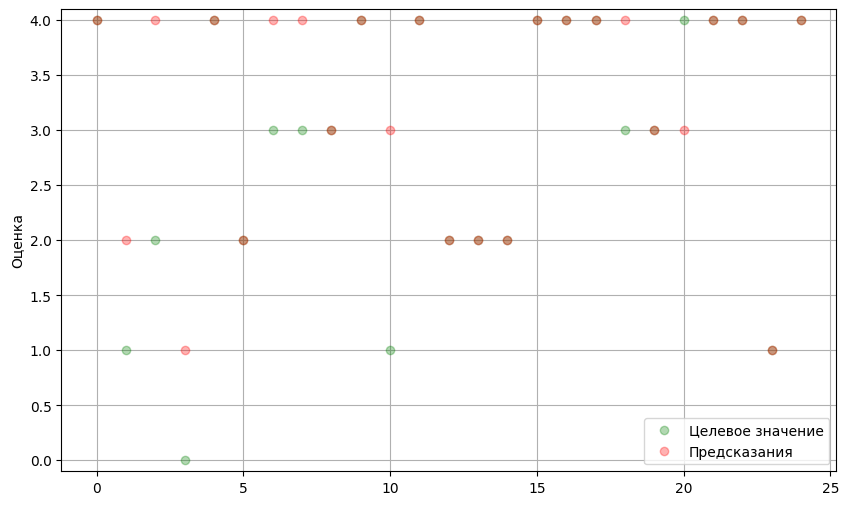

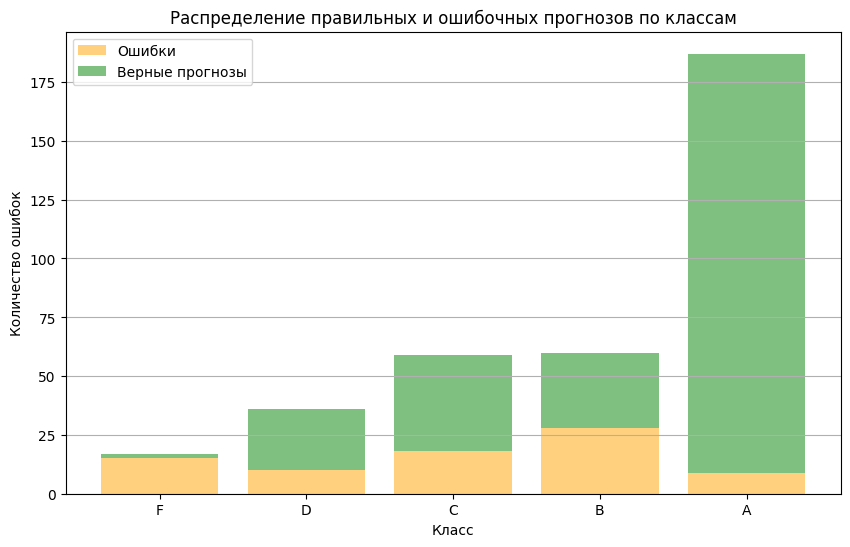

              precision    recall  f1-score   support

           0       1.00      0.12      0.21        17
           1       0.62      0.72      0.67        36
           2       0.71      0.69      0.70        59
           3       0.64      0.53      0.58        60
           4       0.86      0.95      0.90       187

    accuracy                           0.78       359
   macro avg       0.77      0.60      0.61       359
weighted avg       0.78      0.78      0.76       359


Confusion Matrix:
[[  2   9   4   0   2]
 [  0  26   5   2   3]
 [  0   5  41   8   5]
 [  0   1   8  32  19]
 [  0   1   0   8 178]]
Test  Loss: 0.7195 | Acc: 0.7772 | F1 (macro): 0.6127 | F1 (weighted): 0.7599


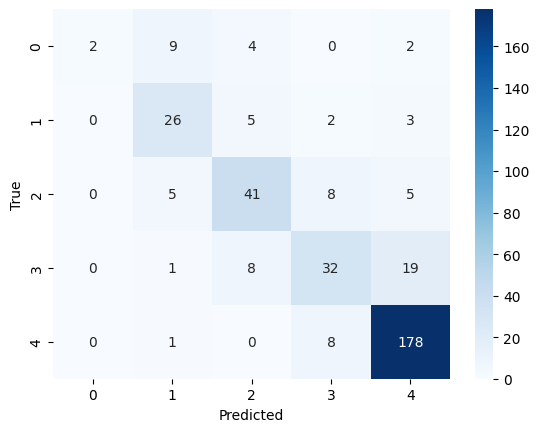

In [2732]:
best_model_path = Path('best_model.pth')
best_model = Net(train_loader, test_loader, device)
best_model = best_model.to(device)

checkpoint = torch.load(best_model_path, map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])

best_model.show_results()

test_loss, test_accuracy, test_f1_macro, test_f1_weighted, class_f1 = best_model.evaluate_model(criterion)
print(f'Test  Loss: {test_loss:.4f} | Acc: {test_accuracy:.4f} | F1 (macro): {test_f1_macro:.4f} | F1 (weighted): {test_f1_weighted:.4f}')

### Выводы:
#### Лучшие показатели: accuracy = 0.7772, f1_score_weighted = 0.7599.
#### Полученные результаты в целом удовлетворительны, за исключением того, что всё таки дисбаланс классов слишком большой и для оценки F слишком мало экземпляров, не удалось получить прироста точности при синтетическом увеличении до ещё большего числа экземпляров. За счёт этого для класса F ошибок много. Класс A очевидно самый успешный, классы D и C приемлемы, класс B является вторым по количеству экземпляров классом, но видимо из-за распределения весов классов вес для него был выбран не оптимально, и точность могла бы быть больше.
#### На kaggle не было найдено результата лучше. Многие пользователи не убирали колонку с GPA или GradeClass в зависимости от целевой функции и получали точность от 0.9 до 1, однако согласно описанию датасета это не несёт никакой пользы и в этом нет смысла.
#### На практике вряд ли можно применить данную модель, но данный датасет позволяет поэкспериментировать с балансом классов (прирост + 7% к accuracy в этой задаче)